<a href="https://colab.research.google.com/github/kiranvad/equivariant-MLP/blob/master/examples/01-gaussians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip --quiet install git+https://github.com/mfinzi/equivariant-MLP.git
%pip --quiet install git+https://github.com/kiranvad/spectroscopy.git
%pip --quiet install git+https://github.com/kiranvad/olive-oil-ml.git

     |████████████████████████████████| 50 kB 4.1 MB/s 
     |████████████████████████████████| 47 kB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 118 kB 18.7 MB/s 
     |████████████████████████████████| 57 kB 5.2 MB/s 
     |████████████████████████████████| 280 kB 8.6 MB/s 
     |████████████████████████████████| 1.8 MB 47.4 MB/s 
     |████████████████████████████████| 59 kB 7.3 MB/s 
     |████████████████████████████████| 523 kB 58.2 MB/s 
     |████████████████████████████████| 4.0 MB 42.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 959 kB 39.0 MB/s 
     |████████████████████████████████| 71 kB 8.9 MB/s 


In [2]:
import numpy as np
import pdb

from emlp.reps import V
from emlp.groups import Group, SO, Scaling, I
from emlp.nn import EMLP, MLP

import jax.numpy as jnp
import objax
from oil.datasetup.datasets import split_dataset
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import spectroscopy as ss

 /usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.


In [37]:
# set up hyper-parameters
BATCH_SIZE = 128
ALPHA=3e-3
NUM_EPOCHS=1000
ND = 3000

In [38]:
class Gaussians:
    def __init__(self, N=1000):
        self.N = N
        self.grid_points = np.linspace(0,1,num=100)
        self.Y = np.random.rand(self.N,3)
        self.X = np.array([self.gaussian(self.grid_points, a, b, c) for (a,b,c) in self.Y])
    
    def gaussian(self, x, a, b,c):
        return a*np.exp(-np.power(x - b, 2.) / (2 * np.power(c, 2.)))

    def generate(self, a,b,c):
        x0 = self.grid_points
        x1 = self.gaussian(x0, a, b, c)
        x2 = np.ones(100)
        
        return np.vstack((x0,x1,x2)).T.flatten()
    
    def __getitem__(self, i):
        pos = np.vstack((self.grid_points, self.X[i,:], np.ones(100))).T.flatten()
        label = self.Y[i,:]
        return pos, label
    
    def __len__(self):
        return len(self.Y)
    
datasets = split_dataset(Gaussians(N=ND),splits={'train':-1,'test':0.2, 'val':0.1})
dataloaders = {k:DataLoader(v,batch_size=min(BATCH_SIZE,len(v)),shuffle=(k=='train'),
            num_workers=0,pin_memory=False) for k,v in datasets.items()}

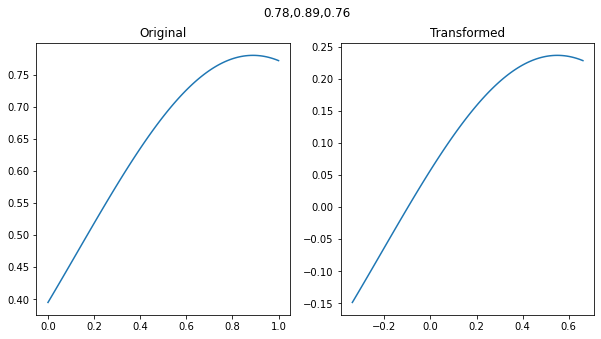

In [39]:
class SE3(Group):
    def __init__(self,n):
        """Special Eulcidean Group in 3 dimensions
        """
        assert n==3, 'This is only for SE(3) not %d'%n
        self.lie_algebra = np.zeros((3,3,3)) 
        self.lie_algebra[0,...] = SO(n).lie_algebra[0,...]
        self.lie_algebra[1,...] = np.array([[0,0,1],[0,0,0],[0,0,0]])
        self.lie_algebra[2,...] = np.array([[0,0,0],[0,0,1],[0,0,0]])
        super().__init__(n)

class T2(Group):
  def __init__(self, n=2):
    """Translation group in two-dimensions
    """
    assert n==2, 'This is only for T(2) not %d'%n
    self.lie_algebra = np.zeros((2,3,3))
    self.lie_algebra[0,...] = np.array([[0,0,1],[0,0,0],[0,0,0]])
    self.lie_algebra[1,...] = np.array([[0,0,0],[0,0,1],[0,0,0]])
    super().__init__(n)

G = T2(2)
#G = SE3(3)
g = G.sample()
v, label = next(iter(dataloaders['train']))
v = jnp.asarray(v[0,...]).reshape(100,3)
label = label[0]
rep_in = 100*V**1

rho_v = rep_in(G).rho_dense(g)@v.flatten()
rho_v = rho_v.reshape(v.shape)

fig, axs = plt.subplots(1,2,figsize=(5*2,5))
axs[0].plot(v[:,0],v[:,1], label='original')
axs[0].set_title('Original')
axs[1].plot(rho_v[:,0], rho_v[:,1], label='transformed')
axs[1].set_title('Transformed')
fig.suptitle(','.join('%.2f'%(i) for i in label.numpy()))
plt.show()

In [40]:
rep_out = 3*V**0
#model = EMLP(rep_in,rep_out,group=G,num_layers=1, ch=32)
model = MLP(rep_in,rep_out,group=G,num_layers=1, ch=32)

In [41]:
# evaluate the model in its random initial stage
def evaluate(model):
  p0 = dataloaders['train'].dataset.generate(1,0.3,0.1)
  pt = dataloaders['train'].dataset.generate(1,0.5,0.1)
  print('Predictions for \np0 : ', model(jnp.asarray(p0)), '\npt : ', model(jnp.asarray(pt)))

print('Random state model predictions: ...\n')
evaluate(model)

Random state model predictions: ...

Predictions for 
p0 :  [ 0.3290977  -0.14670695 -0.27144933] 
pt :  [ 0.15227571 -0.20665872 -0.27603748]


In [42]:
import jax
from objax.functional import softmax


@objax.Jit
@objax.Function.with_vars(model.vars())
def cross_entropy(x,y):
    """ Standard cross-entropy loss """
    logits = model(x,training=True)
    logp = jax.nn.log_softmax(logits)
    ll = jnp.take_along_axis(logp, jnp.expand_dims(y, axis=1), axis=1)
    ce = -jnp.mean(ll)
    return ce

@objax.Jit
@objax.Function.with_vars(model.vars())
def mean_square(x, y):
    yhat = model(x)
    return ((yhat-y)**2).mean()


loss = lambda x,y : mean_square(x,y)

opt = objax.optimizer.Adam(model.vars())

grad_and_val = objax.GradValues(loss, model.vars())

@objax.Jit
@objax.Function.with_vars(model.vars()+opt.vars())
def train_op(x, y, lr):
    g, v = grad_and_val(x, y)
    opt(lr=lr, grads=g)
    return v
    

In [43]:
test_losses = []
train_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    train_losses.append(np.mean([train_op(jnp.array(x),jnp.array(y),ALPHA) for (x,y) in dataloaders['train']]))
    if not epoch%10:
        test_losses.append(np.mean([loss(jnp.array(x),jnp.array(y)) for (x,y) in dataloaders['test']]))

  0%|          | 0/1000 [00:00<?, ?it/s]

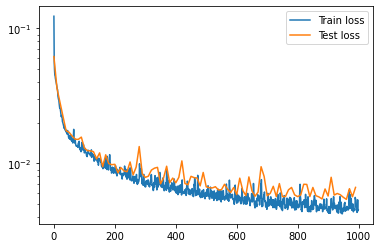

In [44]:
plt.plot(np.arange(NUM_EPOCHS),train_losses,label='Train loss')
plt.plot(np.arange(0,NUM_EPOCHS,10),test_losses,label='Test loss')
plt.legend()
plt.yscale('log')

In [45]:
print('Trained state model predictions: ...\n')
evaluate(model)

Trained state model predictions: ...

Predictions for 
p0 :  [0.9275267  0.28379706 0.08417642] 
pt :  [0.78936905 0.52885675 0.101215  ]


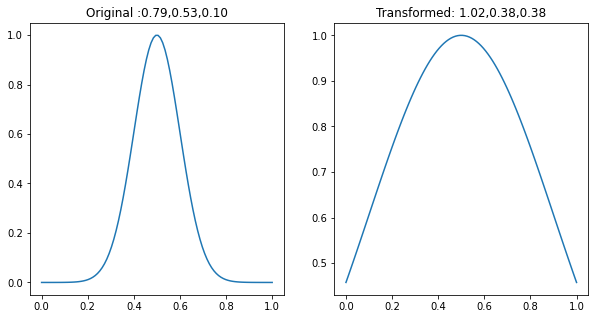

In [46]:
g = G.sample()
v = dataloaders['train'].dataset.generate(1,0.5,0.1)
feat_v = model(jnp.asarray(v))

rho_v = dataloaders['train'].dataset.generate(1,0.5,0.4)
feat_rhov = model(jnp.asarray(rho_v))

v = v.reshape(100,3)
rho_v = rho_v.reshape(v.shape)

fig, axs = plt.subplots(1,2,figsize=(5*2,5))
axs[0].plot(v[:,0],v[:,1], label='original')
axs[0].set_title('Original :'+','.join('%.2f'%i for i in feat_v))
axs[1].plot(rho_v[:,0], rho_v[:,1], label='transformed')
axs[1].set_title('Transformed: '+','.join('%.2f'%i for i in feat_rhov))
plt.show()